<a href="https://colab.research.google.com/github/ramanakshay/Optimal-Transport/blob/main/notebooks/multi_marginal_ot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Marginal Optimal Transport

## Import Libraries

In [75]:
!pip install pot  # Pip Installs Packages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
user = 'ramanakshay'
repo = 'Optimal-Transport'

url = f"git+https://github.com/{user}/{repo}.git"
!pip install --upgrade {url}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ramanakshay/Optimal-Transport.git to /tmp/pip-req-build-8gcl8oyz
  Running command git clone -q https://github.com/ramanakshay/Optimal-Transport.git /tmp/pip-req-build-8gcl8oyz


In [77]:
import numpy as np 

import matplotlib.pyplot as plt # plotting

import ot  # ot
import ot.plot
from prettytable import PrettyTable

import time # measure time
from numpy import random

In [78]:
from utils.plot import plot_matrix,plot_2d_map
from utils.dist import find_cost_matrix,find_cost_matrix_old

##Coulomb Cost

In [141]:
def gaussian_mix(n,mu,std,scale = None):
  assert len(mu) == len(std)
  if scale == None:
    scale = [1]*len(mu)
  x = np.arange(n, dtype = np.float64)
  h = 0
  for i in range(len(mu)):
    h += np.exp(-(x - mu[i]) ** 2 / (2 * std[i] ** 2))*scale[i]
  return h / h.sum()

In [142]:
def find_cost_tensor(n,X,p = 1):
  C = np.zeros((size,)*n)
  for i in range(n):
    for j in range(n):
      if i < j:
        shape = [1]*n
        shape[i] = shape[j] = size
        shape = tuple(shape)
        C += find_cost_matrix_old(X[i].reshape(size,1),X[j].reshape(size,1),1,dist=("coulomb",1)).reshape(shape)
  return C

## Sinkhorn Algorithm

In [143]:
def sinkhorn(A,C,epsilon,niter):
  n = A.shape[0]
  size = A.shape[1]
  u = np.ones((n,size))
  K = np.exp(-C/epsilon)

  P = np.copy(K)
  for it in range(niter):
    for i in range(n):
      shape = [1]*n
      shape[i] = size
      shape = tuple(shape)
      temp = u[i].reshape(shape)
      P = P / temp #remove u[i] from p

      axes = list(range(n))
      axes.remove(i)
      axes = tuple(axes)
      vec = np.sum(P,axis = axes)
      u[i] = A[i] / vec

      temp = u[i].reshape(shape)
      P = P * temp #multiply updated value
  
  return P

In [144]:
def auto_sinkhorn(A,C,epsilon,error):
  n = A.shape[0]
  size = A.shape[1]
  u = np.ones((n,size))
  K = np.exp(-C/epsilon)

  P = np.copy(K)
  while(True):
    for i in range(n):
      shape = [1]*n
      shape[i] = size
      shape = tuple(shape)
      temp = u[i].reshape(shape)
      P = P / temp #remove u[i] from p

      axes = list(range(n))
      axes.remove(i)
      axes = tuple(axes)
      vec = np.sum(P,axis = axes)
      u[i] = A[i] / vec

      temp = u[i].reshape(shape)
      P = P * temp #multiply updated value
    
    flag = True
    for i in range(n):
      axes = list(range(n))
      axes.remove(i)
      axes = tuple(axes)
      vec = np.sum(P,axis = axes)
      if (np.any(abs(np.sum(P,axis = axes) - A[i]) >= error)):
        flag = False
    
    if(flag):
      break

  return P

## 1D Marginals

In [145]:
n = 3
size = 100

A = np.empty((n,size), float)
A[0] = gaussian_mix(size,[10,50],[5,15],[2,1])
A[1] = gaussian_mix(size,[15,60],[15,10],[1.5,1])
A[2] = gaussian_mix(size,[20,80],[10,5],[1,1])
#A[3] = gaussian_mix(size,[25,70],[5,10],[1.5,1])

x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

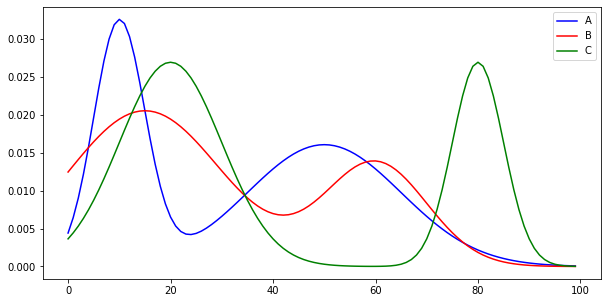

In [146]:
#Plot distributions
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b', label='A')
plt.plot(x, A[1], 'r', label='B')
plt.plot(x, A[2], 'g', label='C')
#plt.plot(x, A[3], 'y', label='D')
plt.legend()
plt.show()

(100, 100, 100)


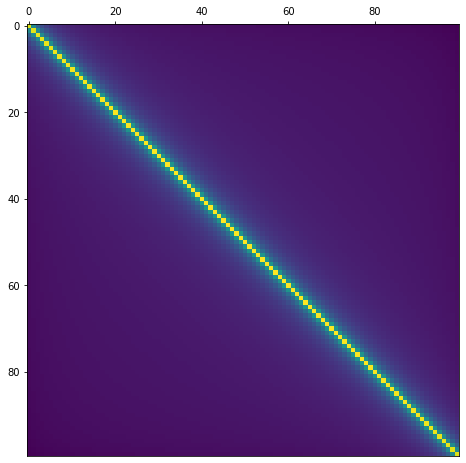

In [147]:
C = find_cost_tensor(n,X)
Cm = np.sum(C,axis = 2)
print(C.shape)
plot_matrix(Cm,x,x)

In [150]:
P = auto_sinkhorn(A,C,1e-3,1e-6)
# P = sinkhorn(A,C,1e-3,100)
# Pold = sinkhorn_old(A,C,1e-3,100)

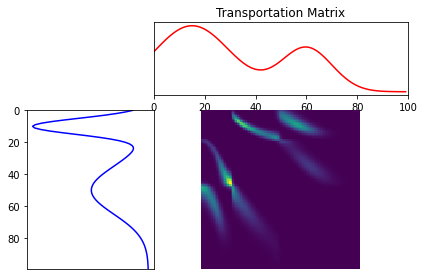

In [152]:
Pm = np.sum(P,axis = 2)
ot.plot.plot1D_mat(A[0], A[1], Pm, 'Transportation Matrix')

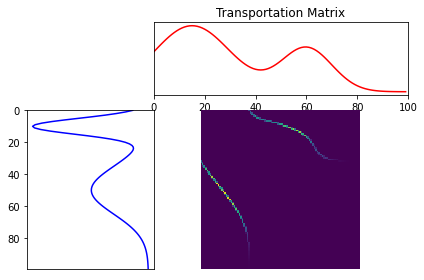

In [153]:
Ce = find_cost_matrix(x,x,1,dist = ("coulomb",1))
Pe = ot.emd(A[0],A[1],Ce)
ot.plot.plot1D_mat(A[0], A[1], Pe, 'Transportation Matrix')

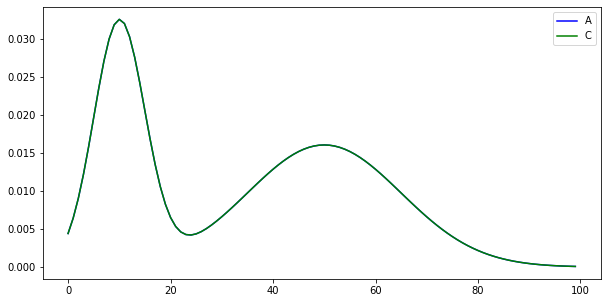

In [154]:
Pv = np.sum(P,axis = (1,2))
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b', label='A')
plt.plot(x, Pv, 'g', label='C')
plt.legend()
plt.show()

In [155]:
OT = np.sum(C*P)
print(OT)

0.09420556301080944
